# Compare background subtracted SSPALS traces (looped data)

<span style="color:red">IMPORTANT</span> - This notebook reads HDF5 files. Always PAUSE Sequencer.vi to run analysis for current sequence (HDF5 r/w conflict)!

In [1]:
#import python packages
import os
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline
import oskar, sspals

### Import

In [2]:
rid = '20160504_205741'
h5 = oskar.H5Data(rid)             # data
h5.load_log()
vDF = h5.var_df()
uDF = h5.unique_df()
out_dire = h5.out_dire("Traces")    # output
h5.pprint()

20160504_205741
   Author:	 AA
   Description:  n = 10 high resolution lineshape


In [3]:
uDF.head()

,DLY_EA,DLY_GA,IR,VOL_u100,VOL_u101
VID,,,,,
1,6.470000e-07,0.000001,756.20,2000,1600
2,6.470000e-07,0.000001,756.21,2000,1600
3,6.470000e-07,0.000001,757.50,2000,1600
4,6.470000e-07,0.000001,757.53,2000,1600
5,6.470000e-07,0.000001,757.56,2000,1600


In [4]:
#uDF[uDF.IR > 758.5]

## Import traditional SSPALS analysis

In [8]:
DF = oskar.average_data([rid], verbose=True, loop=True, fils=['avL_SSPALS_CH_L2[  1.00e-07   4.50e-07   1.20e-06].dat'])
DF.head()

Loaded: avL_SSPALS_CH_L2[  1.00e-07   4.50e-07   1.20e-06].dat


DLY_EA    DLY_GA      IR  VOL_u100  VOL_u101  \
RID             VID                                                       
20160504_205741 1    6.470000e-07  0.000001  756.20      2000      1600   
                2    6.470000e-07  0.000001  756.21      2000      1600   
                3    6.470000e-07  0.000001  757.50      2000      1600   
                4    6.470000e-07  0.000001  757.53      2000      1600   
                5    6.470000e-07  0.000001  757.56      2000      1600   

                     t0_ra_reps    t0_ra_mean     t0_ra_std     t0_ra_sem  \
RID             VID                                                         
20160504_205741 1         600.0  1.556465e-07  2.586232e-10  1.055825e-11   
                2         598.0  1.557541e-07  2.565375e-10  1.049060e-11   
                3         699.0  1.556082e-07  3.118648e-10  1.179581e-11   
                4         600.0  1.556897e-07  2.776808e-10  1.133627e-11   
                5         594.0  1.557066e-07  2.851090e-10  1.169816e-11   

                     DF_ra_reps  DF_ra_mean  DF_ra_std  DF_ra_sem  
RID             VID                                                
20160504_205741 1         600.0    0.078811   0.006798   0.000278  
                2         598.0    0.079531   0.006993   0.000286  
                3         699.0    0.079848   0.006784   0.000257  
                4         600.0    0.079263   0.006976   0.000285  
                5         594.0    0.079913   0.006939   0.000285

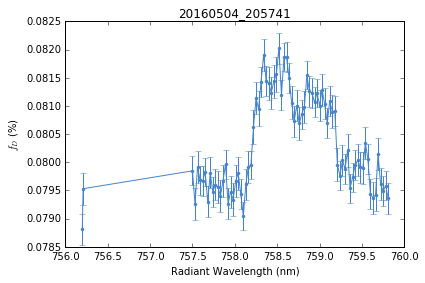

In [33]:
X = 'IR'
Y = 'DF_ra'
#plot setup
fig, ax = plt.subplots()
j = 0
sg = DF.loc[rid].sort_values(by=X)
x_vals = sg[X].values
y_vals = sg[Y+'_mean'].values
yerr = sg[Y+'_sem'].values
ax.errorbar(x_vals, y_vals, yerr=yerr, fmt ='.-', color=oskar.colors[j%7])

#format
ax.set_ylabel("$f_{D}$ (%)")
ax.set_xlabel("Radiant Wavelength (nm)")
#ax.set_xlim(x.min(), x.max())
ax.set_title(rid)
plt.tight_layout()

#save data
fileout = os.path.join(out_dire, "DF_linescan2.png")
plt.show()

### Define the background trace to which all others are compared

In [39]:
background_squids = vDF[vDF['IR'] < 758].index.values
background_squids

array([  2,   5,   9,  11,  23,  31,  32,  33,  35,  36,  40,  42,  47,
        51,  56,  57,  60,  77,  79,  85,  89,  99, 101, 103, 107, 111,
       112, 114, 118, 125, 126, 135, 137, 142, 143, 146, 147, 160, 166,
       167, 170, 172, 173, 176, 179, 182, 186, 191, 192, 198, 199, 202,
       218, 219, 226, 227, 234, 241, 243, 245, 247, 253, 255, 260, 264,
       269, 277, 288, 289, 291, 295, 298, 302, 306, 309, 318, 323, 325,
       328, 329, 338, 340, 344, 355, 358, 361, 369, 373, 375, 377, 383,
       384, 391, 398, 399, 403, 404, 407, 416, 421, 422, 427, 430, 431,
       439, 448, 450, 452, 455, 461, 464, 465, 474, 477, 481, 492, 499,
       500, 509, 514], dtype=int64)

In [70]:
hi, osc_hi = h5.load_array(background_squids, chan_hi)
low, osc_low = h5.load_array(background_squids, chan_low)
limits = [-1e-8, 1.7e-7, 6.5e-7]
dt = osc_hi['dt']
chmx_bk = sspals.chmx(hi, low, invert=True, n_bsub=100,
                   validate=True, min_range=0.1)
DF = sspals.sspals(chmx, dt, limits=limits)
x = (np.arange(np.shape(chmx)[1])*dt) - DF.t0.mean()

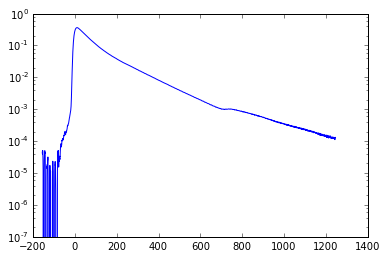

In [72]:
reps_bk = np.shape(chmx_bk)[0]
av_bk = np.mean(chmx_bk, axis=0)
error_bk = np.std(chmx_bk, axis=0) / np.sqrt(reps_bk)
plt.plot(x*1e9, av_bk)
plt.yscale('log')
plt.show()

### Find the background subtracted traces

In [64]:
# traces
diff = []
diff_error = []
for vid in tqdm(uDF.index):
    squids = vDF[(vDF == uDF.loc[vid]).all(1)].index.values
    hi, osc_hi = h5.load_array(squids, chan_hi)
    low, osc_low = h5.load_array(squids, chan_low)
    dt = osc_hi['dt']
    chmx = sspals.chmx(hi, low, invert=True, n_bsub=100,
                       validate=True, min_range=0.1)
    reps = np.shape(chmx)[0]
    average = np.mean(chmx, axis=0)
    error = np.std(chmx, axis=0)/ np.sqrt(reps)
    bksub = average/np.sum(average) - av_bk/np.sum(av_bk)
    diff.append(bksub)
    error_bksub = np.sqrt((error/np.sum(average))**2.0 + (error_bk/np.sum(av_bk))**2.0)
    diff_error.append(error_bksub)
diff = np.array(diff)
diff_error = np.array(diff_error)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.errorbar(x*1e9, diff[0], yerr=diff_error[0])
ax.plot(x*1e9, diff[0], ls='-', c='k')

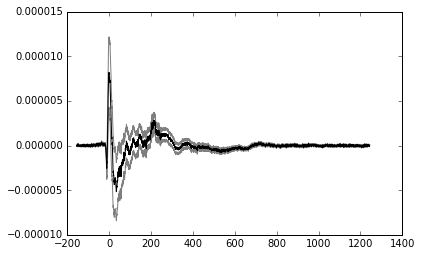

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
slice_ = 0
ax.plot(x*1e9, diff[slice_] + diff_error[slice_], ls='-', c='k', alpha=0.5)
ax.plot(x*1e9, diff[slice_], ls='-', c='k')
ax.plot(x*1e9, diff[slice_] - diff_error[slice_], ls='-', c='k', alpha=0.5)
plt.show()

### sum the absolute value of the background subtracted traces

In [54]:
diff_vals = np.sum(abs(diff), axis=1)
error_vals = np.sqrt(np.sum(diff_error**2.0, axis=1))

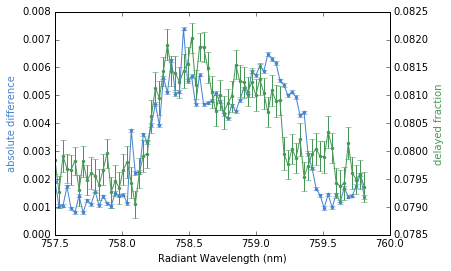

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.errorbar(x_vals, diff_vals, yerr=error_vals, fmt='.-', color=oskar.colors[0], label='abs')
ax.set_ylabel('absolute difference', color=oskar.colors[0])

ax2 = ax.twinx()
ax2.errorbar(x_vals, y_vals, yerr=yerr, fmt ='.-', color=oskar.colors[1], label='trad.')
ax2.set_ylabel('delayed fraction', color=oskar.colors[1])

ax.set_xlabel("Radiant Wavelength (nm)")

ax.set_xlim(757.5,760)
plt.show()

### progressively introduce a mask to the summing region

In [16]:
threeD_vals = []
for i in trange(len(diff[0])):
    d_vals = np.sum(abs(diff[:, i:]), axis=1)
    threeD_vals.append(d_vals)
threeD_vals = np.array(threeD_vals)

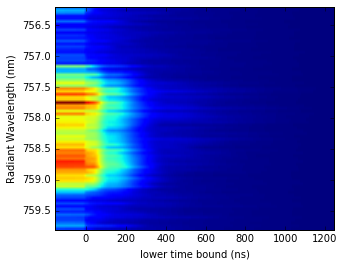

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(threeD_vals.T, aspect='auto', extent=[x.min(),x.max(),x_vals.max(),x_vals.min()]) # assumes linear xscale
ax.set_xlabel("lower time bound (ns)")
ax.set_ylabel("Radiant Wavelength (nm)")
plt.show()

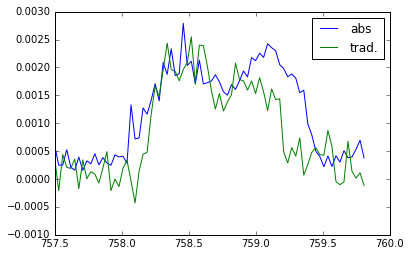

In [29]:
plt.plot(x_vals, 0.4*(threeD_vals[100] - np.mean(threeD_vals[1000][0:5])), label='abs')
plt.plot(x_vals, (y_vals - np.mean(y_vals[0:5])), label='trad.')
plt.legend()
plt.xlim(757.5,760)
plt.show()